In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../src/")

%matplotlib inline

import nanonets
import nanonets_utils

In [75]:
# Network Parameter
N_electrodes    = 8
N_particles     = 3
N_jumps         = 5000
topology        = {
    "Nx"                : N_particles,
    "Ny"                : N_particles,
    "Nz"                : 1,
    "e_pos"             :  [[0,0,0],[int((N_particles-1)/2),0,0],[N_particles-1,0,0],[0,int((N_particles-1)/2),0],[0,N_particles-1,0],
                            [int((N_particles-1)/2),N_particles-1,0],[N_particles-1,int((N_particles-1)/2),0],[N_particles-1,N_particles-1,0]],
    "electrode_type"    : ['constant','floating','floating','floating','floating','floating','floating','floating']
}
sim_dic         = {
    "error_th"        : 0.0,      
    "max_jumps"       : N_jumps,
    "eq_steps"        : 10000,
    "jumps_per_batch" : 1,
    "kmc_counting"    : False,
    "min_batches"     : 1
}

In [76]:
# Voltage Values
N_voltages                  = 1000
U_amplitude                 = 0.1
voltages                    = np.zeros(shape=(N_voltages,N_electrodes+1))
# voltages[:,:N_electrodes]   = np.tile(np.random.uniform(low=-U_amplitude, high=U_amplitude, size=(1,N_electrodes)), (N_voltages,1))
voltages[:,0]               = np.random.uniform(low=-U_amplitude, high=U_amplitude, size=N_voltages)
# voltages[:,:N_electrodes]   = np.random.uniform(low=-U_amplitude, high=U_amplitude, size=(N_voltages,N_electrodes))
voltages

array([[-0.08925424,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06976074,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0865165 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.05634023,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05019081,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06367403,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [77]:
target_electrode    = 7
sim_class           = nanonets.simulation(network_topology='cubic', topology_parameter=topology)
sim_class.run_const_voltages(voltages=voltages, target_electrode=target_electrode, output_potential=True, verbose=True, sim_dic=sim_dic, save_th=0.1)

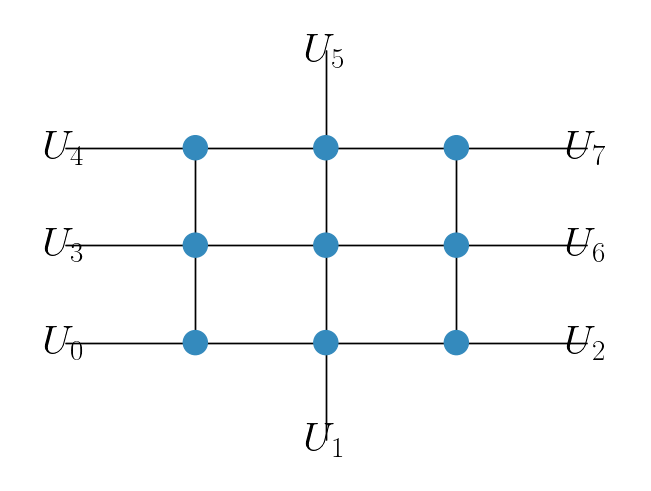

In [78]:
fig     = plt.figure(layout='constrained')
ax      = fig.add_subplot()
fig, ax = nanonets_utils.display_network(sim_class, fig, ax, provide_electrode_labels=[f"$U_{i}$" for i in range(N_electrodes)], font_size=30)
# fig.savefig("plots/network.pdf")

In [12]:
output_vals         = pd.DataFrame(sim_class.return_output_values())
landscape_series    = sim_class.pot_per_it
electrode_votalges  = {i : pd.DataFrame(landscape_series[i]).iloc[:,:8]*1000 for i in range(N_voltages)}
time_vals           = {i : np.cumsum(sim_class.time_values[i])*1e9 for i in range(N_voltages)}
not_finished        = output_vals[output_vals[1] != N_jumps].index

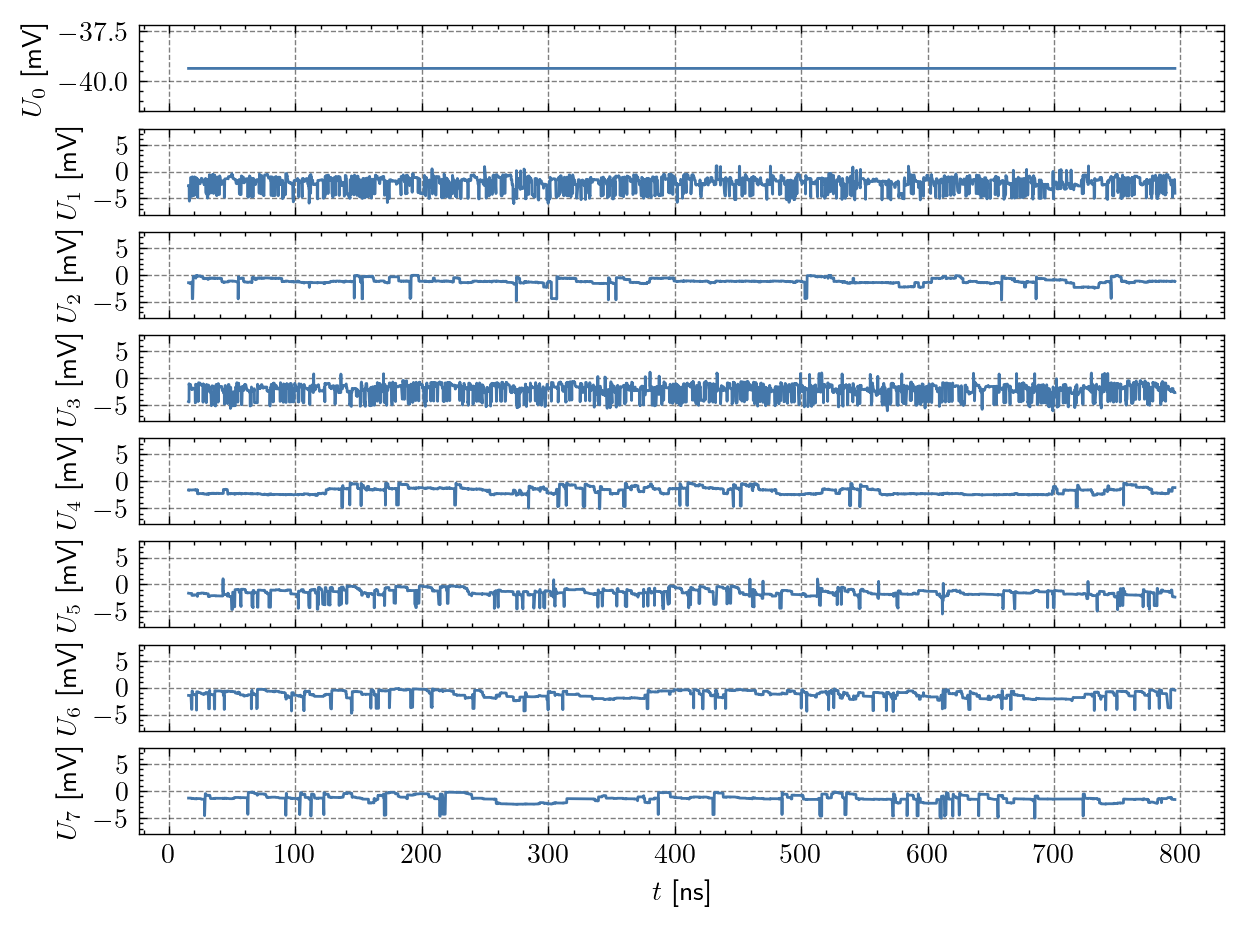

In [7]:
start       = 100
volt_set    = 6

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2.0)
    fig.set_figheight(fig.get_figheight()*2.0)

    for i in range(8):

        ax  = fig.add_subplot(8,1,i+1)
        ax.plot(time_vals[volt_set][start:], electrode_votalges[volt_set].iloc[start:,i])

        # ax.set_xlim(1000,2000)
        if i == 0:
            pass
            # ax.set_ylim(60,65)
        else:
            ax.set_ylim(-8,8)

        ax.set_ylabel(f"$U_{i}$ [mV]")

        if i != 7:
            ax.set_xticklabels("")

    ax.set_xlabel("$t$ [ns]")

In [13]:
not_finished

Index([  3,   4,  17,  34,  41,  46,  54,  62,  84,  86,
       ...
       930, 943, 949, 957, 965, 969, 972, 975, 988, 991],
      dtype='int64', length=117)

In [15]:
start           = 200
avg_corr_vals   = pd.DataFrame(np.nanmean([electrode_votalges[i].iloc[start:,:].corr() for i in range(N_voltages) if i not in not_finished], axis=0))
matrix          = np.triu(np.ones_like(avg_corr_vals, dtype=bool))
rename_mapper   = {i : f"$U_{i}$" for i in range(N_electrodes)}
avg_corr_vals   = avg_corr_vals.rename(columns=rename_mapper, index=rename_mapper)

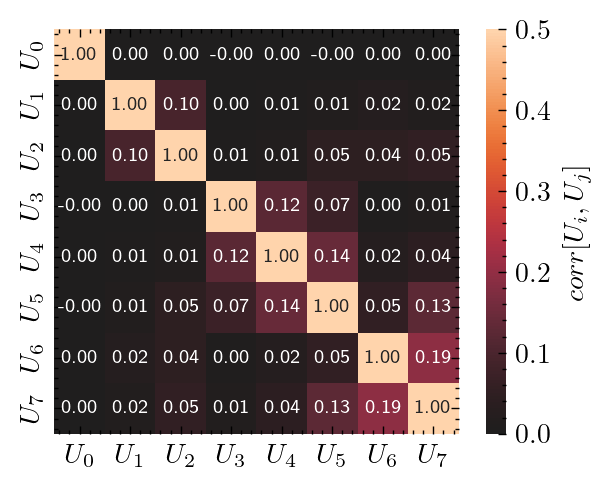

In [66]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.heatmap(avg_corr_vals, vmin=0, vmax=0.5, annot=True, fmt='.2f', center=0, square=True, ax=ax, annot_kws={'size':'x-small'}, cbar_kws={'label':'$corr[U_i,U_j]$'})


# NP Correlation

In [52]:
np_index        = 24
avg_np_corr     = pd.DataFrame(np.mean([np.corrcoef(landscape_series[i][:,N_electrodes:], rowvar=False)[np_index].reshape(N_particles,-1) for i in range(N_voltages) if i not in not_finished], axis=0).reshape(7,-1))
rename_mapper   = {i : f"${i}$" for i in range(N_particles)}
avg_np_corr     = avg_np_corr.rename(columns=rename_mapper, index=rename_mapper)

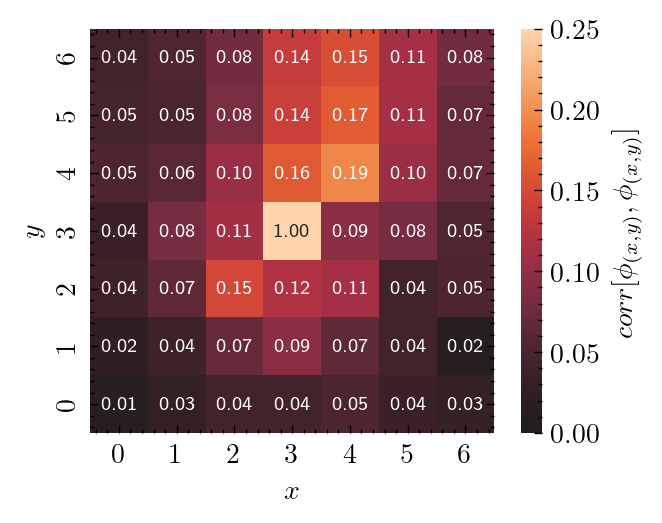

In [65]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax = sns.heatmap(avg_np_corr, ax=ax, vmin=0.0, vmax=0.25, cbar_kws={'label':'$corr[\phi_{(x,y)},\phi_{(x,y)}]$'}, annot=True, fmt='.2f', annot_kws={'size':'x-small'}, center=0, square=True)
    ax.invert_yaxis()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")